# Hierarchical Data Definition

After exploring our variables, we are going to start our modelling process with statistical models such as ETS, ARIMA and Prophet. Although the latter can be argued to have a more ML approach, we will treat it as a statistical model.

In the last notebook we saw that when we go deeper in your hierarchical structure, we have many challenges arising such as intermittent demand, introduction of new products and so on. Also, I have discussed that I am using M5 Forecasting Dataset where majopr goal is to **predict sales by item for next 56 days**. However, this will be a notebook where I will major my discussion in exploring techniques when working with hierarchical forecasting, thus I will just cut the lower level and work only down to department level for following reasons:

 - Even though I still have an intermittent demand, we saw that when data is aggregated effects seems to be less problematic.
 - Introduction of new products clearly changes some deparment / stores / state levels with suddenyl increase in sales, but again, focus will be on statistical techniques aligned with hierarchical reconciliation methods to produce coherent forecast for all levels and how we can improve that using exogenous variables, etc.
 
Therefore, I will use this notebook to build this hierarchical dataset, visualize it and be ready for model definition / training.

## Loading data and libraries

In [13]:
import sys
import os
import gc

sys.path.append("../src")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import cufflinks as cf

cf.go_offline()

import pmdarima as pm

from visualize import get_nodes_edges_position, make_annotations

In [2]:
df_sales = pd.read_csv("../data/raw/sales_train_validation.csv")
df_sales.shape

(30490, 1919)

## Visualizing hierarchy

In [100]:
# Defining list of tuples as hierarchy

# First level
second_level_nodes = df_sales['state_id'].unique().tolist()
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'CA'), ('total', 'TX'), ('total', 'WI')]

In [101]:
second_to_third = list(df_sales.groupby(['state_id', 'store_id']).groups.keys())
second_to_third[:5]

[('CA', 'CA_1'),
 ('CA', 'CA_2'),
 ('CA', 'CA_3'),
 ('CA', 'CA_4'),
 ('TX', 'TX_1')]

In [102]:
root_edges += second_to_third

In [103]:
df_sales["store_cat_id"] = df_sales["store_id"] + "_" + df_sales["cat_id"]
third_to_fourth = list(df_sales.groupby(['store_id', 'store_cat_id']).groups.keys())
root_edges += third_to_fourth

In [104]:
df_sales["cat_dept_id"] = df_sales["store_cat_id"] + "_" + df_sales["dept_id"]
third_to_fourth = list(df_sales.groupby(['store_cat_id', 'cat_dept_id']).groups.keys())
root_edges += third_to_fourth

In [105]:
root_edges

[('total', 'CA'),
 ('total', 'TX'),
 ('total', 'WI'),
 ('CA', 'CA_1'),
 ('CA', 'CA_2'),
 ('CA', 'CA_3'),
 ('CA', 'CA_4'),
 ('TX', 'TX_1'),
 ('TX', 'TX_2'),
 ('TX', 'TX_3'),
 ('WI', 'WI_1'),
 ('WI', 'WI_2'),
 ('WI', 'WI_3'),
 ('CA_1', 'CA_1_FOODS'),
 ('CA_1', 'CA_1_HOBBIES'),
 ('CA_1', 'CA_1_HOUSEHOLD'),
 ('CA_2', 'CA_2_FOODS'),
 ('CA_2', 'CA_2_HOBBIES'),
 ('CA_2', 'CA_2_HOUSEHOLD'),
 ('CA_3', 'CA_3_FOODS'),
 ('CA_3', 'CA_3_HOBBIES'),
 ('CA_3', 'CA_3_HOUSEHOLD'),
 ('CA_4', 'CA_4_FOODS'),
 ('CA_4', 'CA_4_HOBBIES'),
 ('CA_4', 'CA_4_HOUSEHOLD'),
 ('TX_1', 'TX_1_FOODS'),
 ('TX_1', 'TX_1_HOBBIES'),
 ('TX_1', 'TX_1_HOUSEHOLD'),
 ('TX_2', 'TX_2_FOODS'),
 ('TX_2', 'TX_2_HOBBIES'),
 ('TX_2', 'TX_2_HOUSEHOLD'),
 ('TX_3', 'TX_3_FOODS'),
 ('TX_3', 'TX_3_HOBBIES'),
 ('TX_3', 'TX_3_HOUSEHOLD'),
 ('WI_1', 'WI_1_FOODS'),
 ('WI_1', 'WI_1_HOBBIES'),
 ('WI_1', 'WI_1_HOUSEHOLD'),
 ('WI_2', 'WI_2_FOODS'),
 ('WI_2', 'WI_2_HOBBIES'),
 ('WI_2', 'WI_2_HOUSEHOLD'),
 ('WI_3', 'WI_3_FOODS'),
 ('WI_3', 'WI_3_HOBBIE

In [106]:
df_sales.head(4)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,store_dept_id,total,store_cat_id,cat_dept_id
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,3,0,1,1,CA_1_HOBBIES_1,Total,CA_1_HOBBIES,CA_1_HOBBIES_HOBBIES_1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,0,CA_1_HOBBIES_1,Total,CA_1_HOBBIES,CA_1_HOBBIES_HOBBIES_1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,1,1,1,CA_1_HOBBIES_1,Total,CA_1_HOBBIES,CA_1_HOBBIES_HOBBIES_1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,1,3,7,2,CA_1_HOBBIES_1,Total,CA_1_HOBBIES,CA_1_HOBBIES_HOBBIES_1


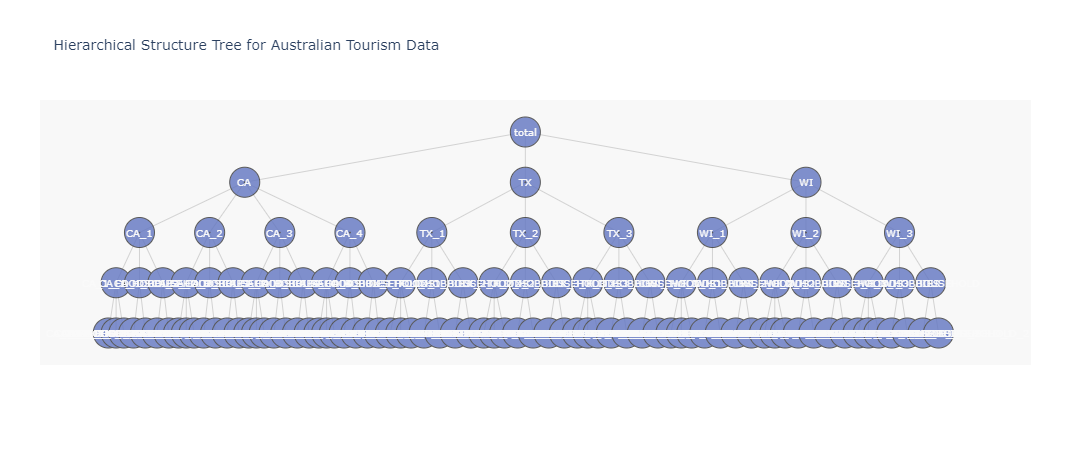

In [107]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for Australian Tourism Data',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

Now that we have our hierarchy definition, we will aggregate data to work with this structure.
It is important to note that department can be disaggregated in different levels, so it is more fitted to work in Grouped Time Series, they are different, because we can change where this level can be 'plugged' in many ways.

In [109]:
df_sales['total'] = 'Total'
df_hier_sales = df_sales.groupby(['total', 'state_id', 'store_id', 'cat_id', 'dept_id']).sum()

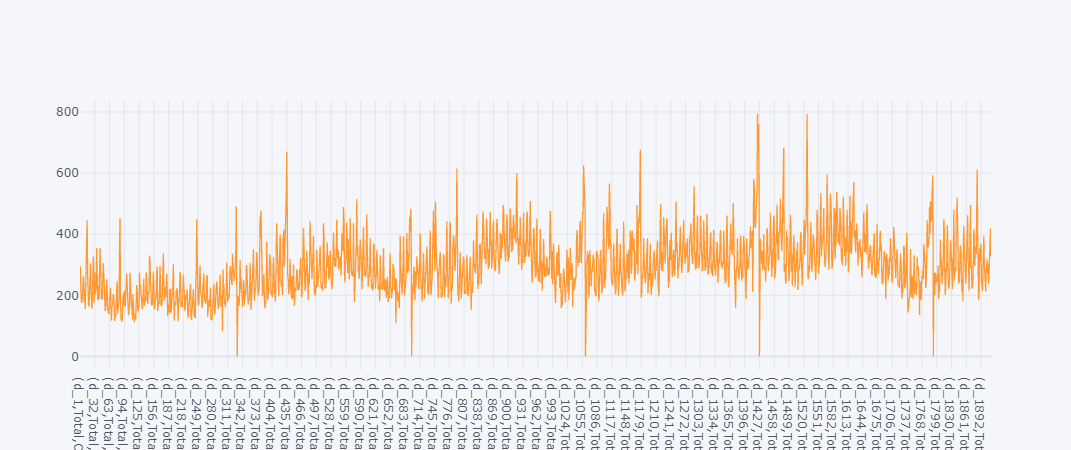

In [112]:
hier_series = [("Total", "CA", "CA_1", "FOODS", "FOODS_1")]
df_hier_sales.loc[hier_series].unstack(level=['total', 'state_id', 'store_id', 'cat_id', 'dept_id']).iplot()

To finish, let's transform d_n columns into respective date columns so we can use exogenous variables later.

In [114]:
df_calendar = pd.read_csv("../data/raw/calendar.csv", parse_dates=["date"])
df_calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [119]:
d_to_date = df_calendar.set_index('d')['date'].to_dict()
df_hier_sales = df_hier_sales.rename(columns=lambda x: d_to_date[x])

In [120]:
df_hier_sales.to_csv('../data/preprocessed/M5_hierarchical_data.csv')